
Давайте возьмем обученную сеть для классификации на  1000 классов [VGG16](https://arxiv.org/pdf/1409.1556.pdf) которая [победила в соревновании ImageNet в 2014](http://www.robots.ox.ac.uk/~vgg/research/very_deep/), и используем ее слои для классификации других классов изображений.

Мы загрузим VGG16, удалим последний ее слой (1000 нейронов с softmax) и заменим его на свой (97 нейронов и классов). Мы зафиксируем веса всех слоев, кроме последнего, т.е. не будем их обучать.

Сравним этот подход с попыткой обучить маленькую нейронную сеть с нуля.

В нашем примере мы используем набор данных из 6000 изображений с 97 классами.

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
%tensorflow_version 2.x
%matplotlib inline
# подключаем библиотеки
import os
import random
import numpy as np
import keras # для нейронных сетей

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import tensorflow as tf

from keras.preprocessing import image # преодобработка изображений
from keras.applications.imagenet_utils import preprocess_input # преодобработка изображений для набора данных imagenet
from keras.models import Sequential # последовательное соединение слоев нейронной сети
from keras.layers import Dense, Dropout, Flatten, Activation # слои, которые будем использовать
from keras.layers import Conv2D, MaxPooling2D # слои, которые будем использовать
from keras.models import Model # объект нейронной сети в который собираются слои

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


### Загрузка набора данных

Мы используем набор данных [CalTech-101](http://www.vision.caltech.edu/Image_Datasets/Caltech101/), который отличается от ImageNet. Он содержит около 9000 размеченных изображений в 101 классе (в архиве файле есть еще 102ой класс с разными случайными картинками из интернета, но он нам не нужен). Мы исключим 5 классов с наибольшим числом изображений (включая 102ой), чтобы иметь классы с примерно одинаковым числом изображений в каждом (50-100), останется около 6000 изображений в 97 классах. Архив с данными хранится на нашем гугл-диске, чтобы скачать его оттуда используем  библиотеку `gdown`.

Если вы захотите обучать на своих классах, то должны сделать набор данных по аналогии с этим, где каждый класс хранится в поддиректориях, названия которых и определяют название классов. `root` - диерктория наборра данных. Вспомогательная функция  `get_image(path)` загружает изображение и масштабирует его к размеру 224x224, чтобы подходило для VGG16.

In [ ]:
import gdown # модуль для загрузки с гугл-диска
url = 'https://drive.google.com/file/d/1GA4rN6FZvi5D6LLdoUAVVkaO_YGRCJou/view?usp=share_link' # адрес
output = '101_ObjectCategories.tar.gz' # название загружаемого файла
gdown.download(url, output, quiet=False) # загружаем


/usr/local/lib/python3.10/dist-packages/gdown/parse_url.py:35: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1GA4rN6FZvi5D6LLdoUAVVkaO_YGRCJou
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1GA4rN6FZvi5D6LLdoUAVVkaO_YGRCJou/view?usp=share_link
To: /content/101_ObjectCategories.tar.gz
1.06MB [00:00, 49.8MB/s]


'101_ObjectCategories.tar.gz'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

# распаковываем
!tar -xzf /content/drive/MyDrive/101_ObjectCategories.tar.gz
# удаляем после распаковки
!rm 101_ObjectCategories.tar.gz
!ls

101_ObjectCategories  drive  sample_data


In [ ]:
root = '101_ObjectCategories' # директория с файлами
exclude = ['BACKGROUND_Google', 'Motorbikes', 'airplanes', 'Faces_easy', 'Faces'] # классы, которые исключаем
train_split, val_split = 0.7, 0.15 # доли данных для обучения и проверки

categories = []
# проходим по всем поддиректориям, они и есть наши классы
categories = [x[0] for x in os.walk(root) if x[0]][1:]
print(categories)
# но исключим некоторые из них
categories = [c for c in categories if c not in [os.path.join(root, e) for e in exclude]]
# посмотрим на классы. Специально оставили в названиях и общее название набора данных, чтобы не перепутать с другими
print(categories)

['101_ObjectCategories/Motorbikes', '101_ObjectCategories/strawberry', '101_ObjectCategories/nautilus', '101_ObjectCategories/umbrella', '101_ObjectCategories/mayfly', '101_ObjectCategories/inline_skate', '101_ObjectCategories/ewer', '101_ObjectCategories/electric_guitar', '101_ObjectCategories/laptop', '101_ObjectCategories/metronome', '101_ObjectCategories/crocodile', '101_ObjectCategories/menorah', '101_ObjectCategories/gramophone', '101_ObjectCategories/cannon', '101_ObjectCategories/okapi', '101_ObjectCategories/grand_piano', '101_ObjectCategories/ant', '101_ObjectCategories/hedgehog', '101_ObjectCategories/cup', '101_ObjectCategories/helicopter', '101_ObjectCategories/panda', '101_ObjectCategories/car_side', '101_ObjectCategories/snoopy', '101_ObjectCategories/octopus', '101_ObjectCategories/sea_horse', '101_ObjectCategories/cougar_face', '101_ObjectCategories/stegosaurus', '101_ObjectCategories/wild_cat', '101_ObjectCategories/beaver', '101_ObjectCategories/pagoda', '101_ObjectC

In [ ]:
# функция для загрузки изображения
def get_image(path):
    #img = image.load_img(path, target_size=(224, 224)) # загружаем изображение и масштабируем
    img = tf.keras.utils.load_img(path, target_size=(224, 224))
    x = tf.keras.utils.img_to_array(img) # конвертируем в массив
    x = np.expand_dims(x, axis=0) # добавляем измерение (batch) 1*224*224*3
    x = preprocess_input(x) # предобработка
    return img, x # возвращаем изображение PIL и массив для него

Загрузка всех изображений.

In [ ]:
data = [] # пустой массив для данных
for c, category in enumerate(categories): # для всех классов, они же поддиректории
    # берем названия всех файлов в ней, объединяем с названием (путем к) самой директории,
    # но только такие, в которых расширение '.jpg','.png','.jpeg'.
    images = [os.path.join(dp, f) for dp, dn, filenames
              in os.walk(category) for f in filenames
              if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
    # для всех изображений класса
    for img_path in images:
        img, x = get_image(img_path) # загружаем его
        data.append({'x':np.array(x[0]), 'y':c}) # добавляем в словарь 'x' - массив изображения и 'y' - номер класса.

# число классов
num_classes = len(categories)

In [ ]:
random.shuffle(data) # перемешаем случайно

Обучающее, тестовое и проверочное множества (70%, 15%, 15%)



In [ ]:
idx_val = int(train_split * len(data)) # индекс начала для проверочного множества
idx_test = int((train_split + val_split) * len(data)) # индекс начала для тестового множества
# разделяем
train = data[:idx_val] #
val = data[idx_val:idx_test] #
test = data[idx_test:] #

In [ ]:
# разделяем данные и метки в отдельные переменные
x_train, y_train = np.array([t["x"] for t in train]), [t["y"] for t in train]
x_val, y_val = np.array([t["x"] for t in val]), [t["y"] for t in val]
x_test, y_test = np.array([t["x"] for t in test]), [t["y"] for t in test]
print(y_test)

[46, 35, 32, 1, 52, 35, 85, 8, 76, 36, 77, 67, 3, 28, 35, 64, 12, 1, 35, 2, 91, 47, 57, 31, 14, 14, 11, 23, 95, 63, 71, 39, 11, 27, 3, 75, 67, 50, 61, 11, 20, 51, 30, 84, 42, 36, 91, 96, 9, 10, 89, 35, 33, 53, 42, 73, 25, 2, 78, 3, 44, 89, 87, 54, 17, 30, 11, 34, 80, 24, 71, 90, 49, 91, 75, 81, 91, 41, 14, 69, 86, 30, 81, 7, 50, 59, 0, 35, 10, 87, 84, 1, 64, 66, 78, 13, 94, 75, 57, 35, 8, 10, 72, 11, 34, 38, 60, 14, 78, 61, 52, 51, 20, 95, 2, 69, 45, 79, 66, 20, 46, 5, 53, 77, 40, 62, 19, 91, 76, 92, 52, 37, 42, 27, 7, 47, 41, 65, 48, 40, 59, 28, 80, 35, 5, 24, 95, 92, 80, 68, 52, 36, 46, 20, 89, 12, 35, 35, 6, 81, 2, 7, 45, 81, 8, 76, 45, 66, 6, 62, 6, 66, 82, 79, 71, 69, 23, 85, 64, 62, 68, 78, 70, 29, 62, 18, 75, 41, 50, 68, 58, 75, 29, 82, 90, 91, 79, 42, 61, 36, 48, 58, 79, 70, 50, 66, 74, 52, 39, 76, 2, 59, 95, 2, 39, 34, 84, 37, 74, 40, 1, 87, 57, 42, 30, 39, 57, 64, 35, 89, 50, 73, 74, 43, 36, 23, 52, 81, 60, 23, 80, 86, 23, 3, 76, 80, 25, 44, 68, 52, 7, 50, 6, 24, 85, 86, 16, 

Предобработка, перевод в float32 и нормализация к 0...1. Кодирование классов.

In [ ]:
# нормализация
x_train = x_train.astype('float32') / 255.
x_val = x_val.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

# конвертируем номера классов в one-hot вектора
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_val = keras.utils.np_utils.to_categorical(y_val, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
print(y_test.shape)

(932, 97)


Что у нас получилось:

In [ ]:
# summary
print("finished loading %d images from %d categories"%(len(data), num_classes))
print("train / validation / test split: %d, %d, %d"%(len(x_train), len(x_val), len(x_test)))
print("training data shape: ", x_train.shape)
print("training labels shape: ", y_train.shape)


finished loading 6209 images from 97 categories
train / validation / test split: 4346, 931, 932
training data shape:  (4346, 224, 224, 3)
training labels shape:  (4346, 97)


Если все правильно, то должен получиться набор изображений, разделенный на `train`, `val` ,и `test`. Размер данных (`n`, 224, 224, 3) где `n` число примеров, указания учителя (`n`, `c`) где `c` - число классов (97 в нашем примере `101_ObjectCategories`).


Посмотрим на некоторые изображения.

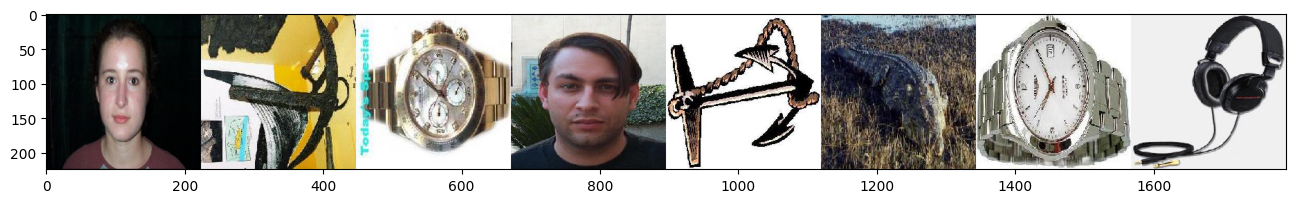

In [ ]:
# названия всех изображений
images = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root) for f in filenames if os.path.splitext(f)[1].lower() in ['.jpg','.png','.jpeg']]
# выбираем случайно 8 штук
idx = [int(len(images) * random.random()) for i in range(8)]
# загружаем эти изображения
imgs = [tf.keras.utils.load_img(images[i], target_size=(224, 224)) for i in idx]
# объединяем в одну строку
concat_image = np.concatenate([np.asarray(img) for img in imgs], axis=1)
# рисуем
plt.figure(figsize=(16,4))
plt.imshow(concat_image)

Итак, аккуратность около 50%. Не так плохо, но и не так хорошо. Для 97 классов, если бы мы случайно угадывали бы класс, получили бы что-то около 1% аккуратности.

# Используем предобученную сеть

Теперь сделаем тоже самое, но будем использовать уже обученную сеть, а заменим только слои для классификации.

In [ ]:
# обученная сеть
#keras.applications.
vgg = keras.applications.VGG16(weights='imagenet', include_top=True)
vgg.summary() # ее описание

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Эта сеть, VGG16, _гораздо_ больше нашей. Содержит 13 сверточных слоев, два полносвязных и более 138 миллионов обучаемых параметров, что почти в 100 раз больше чем было у нас.

VGG16 обучалась на ImageNet и показала [8.8% top-5 ошибку](https://github.com/jcjohnson/cnn-benchmarks), это значит что 91.2% тестовых примеров были классифицированы правильно и верные классы входили в top 5 самых уверенных. top-1 аккуратность около 73%. И при этом в ней не 97, а 1000 классов (случайное угадываение дало бы 0.1% аккуратности).

Чтобы использовать такую сеть мы "отрежем" последний слой с 1000 нейронами (которые отвечают за 1000 классов ImageNet) и заменим его на слой с 97 нейронами для нашего набора данных.

Технически мы не будем ничего отрезать, а сделаем копию слоев VGG до предпоследнего. Используем класс `Model` чтобы создать сеть, объединяя вход VGG, и слои VGG до предпоследнего с новым слоем, названного `new_classification_layer`. Мы возьмем выход предпоследнего слоя VGG и подадим его на новый слой. Не беспокойтесь что при копировании мы тратим память, Keras просто ссылается на нужные места и фактически ничего не копируется.

In [ ]:
# ссылка на вход VGG
inp = vgg.input

# новый полносвязный слой классификации с softmax и num_classes нейронов
new_classification_layer = Dense(num_classes, activation='softmax')

# подключаем новый слой к предпоследнему слою VGG (индекс -2), и делаем ссылку на него
out = new_classification_layer(vgg.layers[-2].output)

# создаем сеть от входа до нового выхода.
model_new = Model(inp, out)


Мы будем обучать эту сеть `model_new` на новых изображениях и классах, но мы заморозим (зафиксируем) веса и смещения у всех слоев, кроме нового последнего и будем обучать только последний слой. Устанавливаем флаг `trainable` в false. Если время и ресурсы позволяют, можете обучать и всю сеть целиком.

В качестве упражнения разрешите обучать также веса предпоследнего слоя.

In [ ]:
# запрещаем обучение всех весов\смещений для слоев кроме последнего
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# на всякий случай последнему слою разрешаем обучаться
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

# компилируем модель и указываем опции обучения
model_new.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary() # печатаем информацию о модели

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Получили сеть похожую на VGG, кроме последнего слоя, имеем 134 миллиона параметров, но обучаемых среди них только 397 тысяч, что в 4 раза меньше чем в прошлой сети.

Обучаем.

In [ ]:
# обучаем
history2 = model_new.fit(x_train, y_train,
                         batch_size=128,
                         epochs=10,
                         validation_data=(x_val, y_val))


Epoch 1/10


Аккуратность около 80%, что  на 30-40% больше, чем ранее. Проверьте, а быстрей ли эта сеть или нет.

Построим графики (оранжевая - новая сеть).

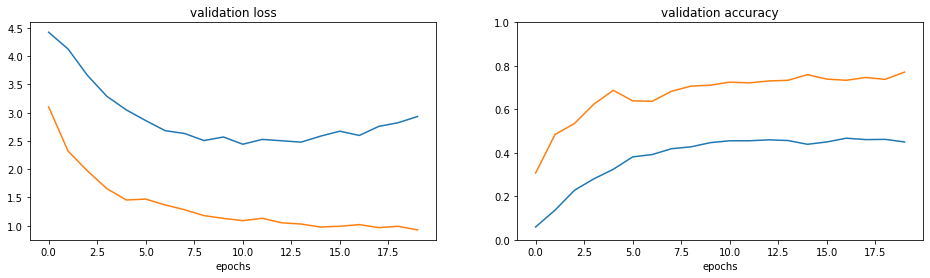

In [ ]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"]) # функция ошибки предыдущей сети
ax.plot(history2.history["val_loss"]) # функция ошибки этой сети
ax.set_title("validation loss")
ax.set_xlabel("epochs")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"]) # аккуратность предыдущей сети
ax2.plot(history2.history["val_accuracy"]) # аккуратность этой сети
ax2.set_title("validation accuracy")
ax2.set_xlabel("epochs")
ax2.set_ylim(0, 1)

plt.show()

Проверим на тестовых данных.

In [ ]:
loss, accuracy = model_new.evaluate(x_test, y_test, verbose=0)

print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 5.186049461364746
Test accuracy: 0.015021459199488163


1/1 [==============================] - 1s 729ms/step
101_ObjectCategories/revolver 0.19618815


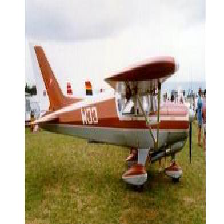

In [ ]:
img, x = get_image('101_ObjectCategories/airplanes/image_0009.jpg')
probabilities = model_new.predict([x])
id=np.argmax(probabilities)
print(categories[id],probabilities[0,id])
img